In [1]:
# Matrix Manipulation
import numpy as np
import pandas as pd

# Utility operations
from numpy import log as ln
import math
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Saving objects
import pickle

# Optimization
from functools import partial
from itertools import chain

# Utility Functions

In [2]:
class HDCModels():
    @classmethod
    def save_model(self, model, filename):
        with open(filename, 'wb') as outp:
            pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)
    
    @classmethod
    def load_model(self, filename):
        with open(filename, 'rb') as inp:
            return pickle.load(inp)

class ItemMemories():
    @classmethod
    def save_IM(self, im, filename):
        with open(filename, 'wb') as outp:
            pickle.dump(im, outp, pickle.HIGHEST_PROTOCOL)
    
    @classmethod
    def load_IM(self, filename):
        with open(filename, 'rb') as inp:
            return pickle.load(inp)
        
class Data():
    @classmethod
    def save(self, data, filename):
        with open(filename, 'wb') as outp:
            pickle.dump(data, outp, pickle.HIGHEST_PROTOCOL)
    
    @classmethod
    def load(self, filename):
        with open(filename, 'rb') as inp:
            return pickle.load(inp)

class SparseHDC():
    # Cyclic shifts the input hypervector arr by shift_count
    @classmethod
    def cyclic_shift(self, arr, shift_count=1):
        return np.concatenate((arr[-shift_count:],arr[:-shift_count]))
    
    @classmethod
    def dot(self, hv1, hv2):
        return np.sum(np.logical_and(hv1, hv2))
    
    @classmethod
    def disp(self, hv):
        s = math.sqrt(len(hv))
        if (s-int(s)):
            return "Must be square"
        
        return np.array(hv).reshape(int(s),int(s))

    # Generate a random sparse HV with dimension and sparsity
    @classmethod
    def generate_random_sparse_HV(self, dim = 10000, sparsity=0.3):
        percent_sparsity = int(100*sparsity)
        return np.vectorize(SparseHDC._generation_threshold)(np.random.randint(101,size=dim), percent_sparsity)
    
    # Generate count number of sparse HVs with dimension and sparsity
    @classmethod
    def generate_random_sparse_HVs(self, count=10, dim = 10000, sparsity=0.3):
        return [SparseHDC.generate_random_sparse_HV(dim, sparsity) for i in range(0,count)]
    
    # Generate a sparse HV with exact sparsity
    @classmethod
    def generate_sparse_HV(self, dim=10000, sparsity=0.3):
        hv = np.repeat(0,dim)
        hv[random.sample(range(0,dim),int(sparsity*dim))]=1
        return hv
    
    # Generate count number of sparse HV with dimension and exact sparsity
    @classmethod
    def generate_sparse_HVs(self, count=10, dim=10000, sparsity=0.3):
        return [SparseHDC.generate_sparse_HV(dim, sparsity) for i in range(0,count)]
    
    # Generate maximally sparse HV with exact dimension and sparsity
    @classmethod
    def generate_max_sparse_HV(self, dim=10000, sparsity=0.3):
        hv = np.repeat(0,dim)
        step = int(1/sparsity)
        hv[[random.sample(range(n*step, (n+1)*step),1)[0] for n in range(0,int(dim/step))]]=1
        return hv
    
    # PRIVATE METHODS
    
    # Returns 1 if num < percent_sparsity where 0<=num<=100
    @classmethod
    def _generation_threshold(self, num, percent_sparsity = 30):
        return 1 if num<percent_sparsity else 0

# Datasets

In [3]:
class ISOLET():
    def __init__ (self, train_filepath = 'isolet1+2+3+4.csv', test_filepath = 'isolet5.csv'):
        self.train = pd.read_csv(train_filepath, header=None)
        self.train_X = self.train[[i for i in range(0,617)]]
        self.train_y = self.train[617]
        self.test = pd.read_csv(test_filepath, header=None)
        self.test_X = self.test[[i for i in range(0,617)]]
        self.test_y = self.test[617]
        
class ItemMemory():
    def __init__(self, cim, base_hvs):
        self.cim = cim
        self.base_hvs = base_hvs

# CIM

In [4]:
class LinearCIM():
    def __init__(self, sparsity=0.3, dim=10000, seed=None):
        self.sparsity = sparsity
        self.dim = dim
        self.seed = seed
    
    def modify_specs(self, sparsity=None, dim=None):
        self.sparsity = sparsity if sparsity else self.sparsity
        self.dim = dim if dim else self.dim

    def generate(self, keys, max_sparse=False):
        if self.seed is None:
            if max_sparse:
                seed = SparseHDC.generate_max_sparse_HV(sparsity=self.sparsity, dim=self.dim)
            else:
                seed = SparseHDC.generate_sparse_HV(sparsity=self.sparsity, dim=self.dim)
        else:
            seed = self.seed
        
        hvs = [seed]
        bit_step = int(np.sum(seed)/(len(keys)-1))
        
        if max_sparse:
            ranges= set(range(0,np.sum(seed)))
            range_length = int(1/self.sparsity)
            
            # Iterate over the seoncds key up
            for i in range(1, len(keys)):
                next_hv = np.copy(hvs[i-1])
                
                # Get random bit_step # of bit ranges
                range_nos = set(random.sample(ranges, k=bit_step))
                
                # Remove these bit ranges in the tracker
                
                # For each range
                for no in range_nos:
                    l = no*range_length
                    u = (no+1)*range_length
                    loc = l + list(next_hv[l:u]).index(1)
                    mov = random.sample(set(range(l,u))-{loc}, k=1)
                    next_hv[loc] = 0
                    next_hv[mov] = 1
                
                ranges -= range_nos
                
                hvs.append(next_hv)
            
        else:
            tracker = pd.Series(np.copy(seed))

            for i in range(1,len(keys)):
                next_hv = np.copy(hvs[i-1])

                # TURN OFF K bits
                turnoff_index = random.sample(list(tracker[tracker==1].index), bit_step)
                tracker[turnoff_index]=-1 #Update to cannot be touched
                next_hv[turnoff_index]=0 #Turn them off from previous hv

                # TURN ON K bits
                turnon_index = random.sample(list(tracker[tracker==0].index), bit_step)
                tracker[turnon_index]=-1 #Update to cannot be touched
                next_hv[turnon_index]=1 #Turn them on

                hvs.append(next_hv)

        return dict(zip(keys,hvs))

# Sparsifiers

In [5]:
# Sparsifying Method

class ThresholdingSparsifier():
    def __init__(self, percent_max_val=0.3, max_val=617):
        self.percent_max_val = percent_max_val
        self.max_val = max_val
    
    def sparsify(self, hv):
        return np.array((hv>self.threshold())).astype(np.int)
    
    def threshold(self):
        return int(self.percent_max_val*self.max_val)

In [6]:
s = ThresholdingSparsifier(percent_max_val = 14/617, max_val = 617)
s.sparsify(np.array([13,14,15]))

array([0, 0, 1])

# Encoding Algorithms

In [257]:
class HoloGNEncoder():
    def __init__(self, M, cim, sparsifier, feature_count=617, shifts=None):
        self.M = M
        self.qlevels = self.quantization_levels(M)
        self.cim_generator = cim
        self.cim = cim.generate(self.qlevels)
        self.sparsifier = sparsifier
        self.shifts = random.sample(range(0,3*feature_count),feature_count) if shifts is None else shifts
        
    def encode(self, features, return_accumulated=False, return_shifted=False):
        # Quantize
        quantized =  (map(self.get_level_hv, features))
        # Get the shifted versions
        shifted = pd.Series(map(SparseHDC.cyclic_shift, quantized, self.shifts))
        if return_shifted:
            return shifted
        # Sum up the shifted versions
        acc = np.sum(shifted)
        # Sparsify
        sparse = self.sparsifier.sparsify(acc)
        return acc if return_accumulated else sparse
        

    def quantization_levels(self, M, min_val=-1, max_val=1, precision=5):
        step = (max_val - min_val) / (M-1)
        qlevels = list(np.arange(min_val, max_val+(0.1*step), step).round(precision))
        return qlevels

    def get_level_hv(self, value, index=False):
        
        # Original
        # closest_value = min(self.qlevels, key=lambda x:abs(x-value))
        
        # IF ELSE CLOSEST VALUE
        value = int(value*10000)
        quantized_value_level = 0
        
        if(value>8888):
            quantized_value_level = 1
        elif(value>6666):
            quantized_value_level = 2
        elif(value>4444):
            quantized_value_level = 3
        elif(value>2222):
            quantized_value_level = 4
        elif(value>0):
            quantized_value_level = 5
        elif(value>-2223):
            quantized_value_level = 6
        elif(value>-4445):
            quantized_value_level = 7
        elif(value>-6667):
            quantized_value_level = 8
        elif(value>-8889):
            quantized_value_level = 9
        else:
            quantized_value_level = 10
        #
        
        closest_value = self.qlevels[10-quantized_value_level]
        
        if index:
            return self.qlevels.index(closest_value)
        else:
            return self.cim[closest_value]

In [297]:
# END-TO-END

class HDC_Classifier():
    def __init__(self, encoder, ACC_THR = 125, training_data=ISOLET()):
        self.encoder = encoder
        self.data = training_data
        self.class_hvs = {}
        self.training_encoded = {}
        self.test_encoded = None
        self.ACC_THR = ACC_THR

    def train(self, save_encodes=True):      
        # Group rows by class
        classes = self.train_y().unique()
        class_rows = {}
        class_hvs = {}
        
    # Segregate the rows into their corresponding classes
        # Sample limit
        # s_limit = 500
    
        # Get the indexes of the rows of different classes
        class_indexes = {}
        for class_ in classes:
            class_indexes[class_] = list(self.train_y()[self.train_y()==class_].index)
            #class_indexes[class_] = list(self.train_y()[0:s_limit][self.train_y()[0:s_limit]==class_].index)

        # Segregated the rows
        for class_ in classes:
            class_rows[class_] = np.array(list(self.train_X().loc[class_indexes[class_]].itertuples(index=False, name=None)))
            #class_rows[class_] = np.array(list(self.train_X()[0:s_limit].loc[class_indexes[class_]].itertuples(index=False, name=None)))

        encoded = {}
        for class_ in classes:
            #print("Encoding... {}% ".format(round(100*class_/classes[-1],2)))
            encoded[class_] = pd.Series(map(self.encoder.encode, class_rows[class_]))
        if save_encodes:
            self.training_encoded = encoded
        
        accumulated = np.array([np.sum(encoded[class_]) for class_ in classes])
        class_sparsifier = ThresholdingSparsifier(percent_max_val = self.ACC_THR/240, max_val=240)
        thresholded = pd.Series(map(class_sparsifier.sparsify, accumulated))
        thresholded.index = range(1,27)
        
        self.class_hvs = dict(thresholded)
        
        return "Done"
    
    def test(self):
        encoded_test = pd.Series(map(self.encoder.encode, np.array(self.test_X())))
        predictions = pd.Series(map(self.query, encoded_test))
        return np.sum(predictions == self.test_y()) #/len(self.test_y())

    # HELPER FUNCTIONS
    def query(self, query_hv):
        d = dict([[class_, SparseHDC.dot(class_hv, query_hv)] for class_,class_hv in self.class_hvs.items()])
        return max(d, key=d.get)
    
    def train_X(self):
        return self.data.train_X
    
    def train_y(self):
        return self.data.train_y
    
    def test_X(self):
        return self.data.test_X
    
    def test_y(self):
        return self.data.test_y

# MODEL DEVELOPMENT

### CONVERT NEXT THREE CELLS TO CODE AND RUN AS NEEDED

In [74]:
# RUN THIS ONCE

isolet = ISOLET()

# Rows in each class
class_indexes = {}
classes = range(1,27)
for class_ in classes:
    class_indexes[class_] = list(isolet.train_y[isolet.train_y==class_].index)

# Rows for each class
# class_rows[class_no][sample_no], class_no corresponds to A-Z but 1-26 instead
class_rows = {}
for class_ in classes:
    class_rows[class_] = np.array(list(isolet.train_X.loc[class_indexes[class_]].itertuples(index=False, name=None)))
    
# 10 rows for each class
test_class_rows = {}

for class_, rows in class_rows.items():
    test_class_rows[class_] = rows[0:10]

In [75]:
def plot_sparsity_vs_accumulation_threshold(encoded_training_data, sparsity, interval=[0,99]):
    classes = list(encoded_training_data.keys())
    dim = len(encoded_training_data[classes[0]][0])
    
    #Accumulate each class
    class_accumulations = [np.sum(encoded_training_data[class_]) for class_ in classes]
    
    for accumulation in class_accumulations:
        sparsities = []
        for i in range(interval[0],interval[1]+1):
            sp = ThresholdingSparsifier(percent_max_val=i/100, max_val=240)
            sparsities.append(np.sum(sp.sparsify(accumulation))/dim)
        plt.plot(range(interval[0],interval[1]+1), sparsities)
        
    plt.title("Sparsity vs Percent ACC THR (Component Sparsity ~{})".format(sparsity))
    plt.xlabel("threshold (% of component count)")
    plt.ylabel("sparsity")
    
def plot_encoding_sparsity_jitter(encoded_training_data, target_sparsity, ENC_THR="x"):
    classes = list(encoded_training_data.keys())
    dim = len(encoded_training_data[classes[0]][0])
    no_of_ones = np.array([])

    for class_ in classes:
        no_of_ones = np.append(no_of_ones, np.vectorize(np.sum)(encoded_training_data[class_]))
        
    sparsities = no_of_ones
    print("Mean sparsity: {}".format(np.average(sparsities)))
    sns.boxplot(sparsities)
    plt.title("Sparsity of Encoded Training Samples at ENC_THR={}".format(ENC_THR))
    plt.xlabel('sample no.')
    plt.ylabel('sparsity')

# TESTING

In [301]:
for shift_rep in range(1,100):
    print(shift_rep)
    dim=5000
    sp=0.02
    ENC_THR=14
    ACC_THR=40
    M=10

    hologn = HoloGNEncoder(M, LinearCIM(dim=dim, sparsity=sp),
                            ThresholdingSparsifier(percent_max_val=ENC_THR/617, max_val=617))

    #Override generated CIM from file
    hologn.cim = ItemMemories.load_IM('im_5k_sp0.02m10_r0.035_thr15_maxsparse.pkl').cim

    #Override encoding shifts with standard shifts
    hologn.shifts = Data.load('std_shifts.pkl').shifts

    #Override 0 shift with 1
    hologn.shifts[hologn.shifts.index(0)] = 1 #87.49
    hologn.shifts[hologn.shifts.index(10)] = 7 #87.68
    hologn.shifts[hologn.shifts.index(20)] = 65 #88.26
    hologn.shifts[hologn.shifts.index(15)] = shift_rep


    classifier = HDC_Classifier(hologn, ACC_THR=ACC_THR)

    classifier.train()
    
    print(classifier.test()/1559)

1


KeyboardInterrupt: 

In [295]:
classifier.train()

Encoding... 3.85% 
Encoding... 7.69% 
Encoding... 11.54% 
Encoding... 15.38% 
Encoding... 19.23% 
Encoding... 23.08% 
Encoding... 26.92% 
Encoding... 30.77% 
Encoding... 34.62% 
Encoding... 38.46% 
Encoding... 42.31% 
Encoding... 46.15% 
Encoding... 50.0% 
Encoding... 53.85% 
Encoding... 57.69% 
Encoding... 61.54% 
Encoding... 65.38% 
Encoding... 69.23% 
Encoding... 73.08% 
Encoding... 76.92% 
Encoding... 80.77% 
Encoding... 84.62% 
Encoding... 88.46% 
Encoding... 92.31% 
Encoding... 96.15% 
Encoding... 100.0% 


'Done'

In [296]:
classifier.test()/1559

0.8774855676715844

In [88]:
f = open("inferences_py.txt", "w+")

for i in range(0, len(classifier.test_X())):
    f.write(str(classifier.query(hologn.encode(classifier.test_X().iloc[i]))))
    f.write("\n")

f.close()

In [100]:
inf_xc = open("inferences_xc.txt", "r")
inf_py = open("inferences_py.txt", "r")
mmtches = 0

for i in range(0, len(classifier.test_X())):
    xc = int(inf_xc.readline().strip()) + 1
    py = int(inf_py.readline().strip()) 
    if xc != py:
        mmtches += 1
        print("i:{}\t xc:{} \t py:{} \t crrct:{}".format(i, xc, py, classifier.test_y()[i]))
        
print("{} mismatches".format(mmtches))

i:42	 xc:16 	 py:22 	 crrct:22.0
i:333	 xc:12 	 py:15 	 crrct:12.0
i:652	 xc:12 	 py:15 	 crrct:15.0
i:717	 xc:16 	 py:22 	 crrct:22.0
i:729	 xc:2 	 py:5 	 crrct:2.0
i:837	 xc:2 	 py:4 	 crrct:4.0
i:1026	 xc:22 	 py:7 	 crrct:20.0
i:1337	 xc:4 	 py:7 	 crrct:20.0
i:1534	 xc:14 	 py:13 	 crrct:14.0
9 mismatches


In [102]:
samp_vals = []
for i in range(0, len(classifier.train_X())):
    samp_vals += list(classifier.train_X().iloc[i])

(array([538290., 234164., 264512., 280888., 314533., 385597., 420567.,
        453239., 437042., 520014.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

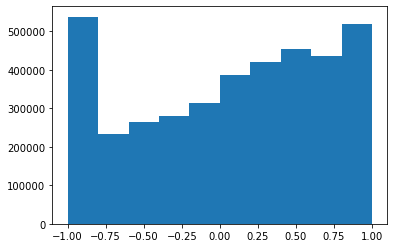

In [104]:
plt.hist(samp_vals)

In [40]:
def hex_to_bin(hex_string):
    output = ""
    
    for c in hex_string:
        output += "{0:04b}".format(int(c, 16))
        
    return output

def bin_to_hex(bin_string):
    output = ""
    temp = ""
    
    for i in range(len(bin_string)-1, -1, -1):
        temp = bin_string[i] + temp
        
        if len(temp)==4:
            output = hex(int(temp, 2))[-1] + output
            temp = ""
    
    return output

def bin_format(bin_string, segment_length=8):
    output = ""
    ctr = 0
    
    for i in range(len(bin_string)-1, -1, -1):
        output = bin_string[i] + output
        ctr += 1
        
        if ctr==segment_length:
            ctr=0
            output = " " + output
    
    return output
            

def hv_to_str(hv):
    return "".join(str(e) for e in hv)

# Retraining

In [35]:
# Generate the accumulation
accumulated = {}
for c, vcs in classifier.training_encoded.items():
    accumulated[c] = np.sum(vcs)
    
original_accumulated = accumulated

In [36]:
def get_alpha(distance_difference):
    if distance_difference:
        if distance_difference > 500:
            return 0.05
        elif distance_difference > 400:
            return 0.1
        elif distance_difference > 300:
            return 0.15
        elif distance_difference > 200:
            return 0.2
        elif distance_difference > 100:
            return 0.25
        else:
            return 0.3
    else:
        return 0

In [37]:
differences = []
misclassified = None

for epoch in range(1,31):
    # print("Epoch {}".format(epoch))
    # QUERY THE TRAINING DATA
    query_results = {}
    alpha = 0.20

    for c, vcs in classifier.training_encoded.items():
        query_results[c] = pd.Series(map(classifier.query, vcs))
    
    misclassified = 0
    # RETRAINING ADJUSTMENT
    for class_ in classes:
        for i in range(0, len(query_results[class_])):
            # IF THE QUERY IS MISCLASSIFIED
            if query_results[class_][i] != class_:
                #print("alpha: {}".format(alpha))
                
                #print("{} Misclassified {} into {}".format(i, class_, query_results[class_][i]))
                misclassified += 1
                
    #alpha = get_alpha(misclassified)
    

    # RETRAINING ADJUSTMENT
    for class_ in classes:
        for i in range(0, len(query_results[class_])):
            # IF THE QUERY IS MISCLASSIFIED
            if query_results[class_][i] != class_:
                #print("alpha: {}".format(alpha))

                # ADD TO THE CORRECT (correct class = class_)
                accumulated[class_] = accumulated[class_] + (alpha * classifier.training_encoded[class_][i])

                # SUBTRACT FROM THE WRONG (wrong class = query_results[class_][i])
                accumulated[query_results[class_][i]] = accumulated[query_results[class_][i]] - (alpha * classifier.training_encoded[class_][i])
    
    #print("\tTotal Misclassified: {} Alpha: {}".format(misclassified, alpha))
    
    # SWEEP ACC_THR

    acc_thr_accuracies = {}

    for acc_thr in range(40,41):
        c_thresh = ThresholdingSparsifier(percent_max_val=acc_thr/240, max_val=240)
        c_thresholded = pd.Series(map(c_thresh.sparsify, list(accumulated.values())))
        c_thresholded.index = range(1,27)
        classifier.class_hvs = dict(c_thresholded)

        accuracy = classifier.test()
        acc_thr_accuracies[acc_thr] = accuracy
        mean_no_of_ones = np.average( [np.sum(v) for v in list(classifier.class_hvs.values())] )
        print("{}".format(accuracy))

    max_acc_thr_accuracy = max(acc_thr_accuracies, key = acc_thr_accuracies.get)
    c_thresh = ThresholdingSparsifier(percent_max_val=max_acc_thr_accuracy/240, max_val=240)
    c_thresholded = pd.Series(map(c_thresh.sparsify, list(accumulated.values())))
    c_thresholded.index = range(1,27)
    classifier.class_hvs = dict(c_thresholded)

0.8678640153944837
0.8794098781270044
0.8614496472097498
0.8505452212957024
0.8319435535599743
0.844772289929442
0.8364336112892881
0.8505452212957024
0.8614496472097498
0.8678640153944837
0.8903143040410519
0.8871071199486851
0.8883899935856319
0.8794098781270044
0.8838999358563181
0.876844130853111
0.8928800513149455
0.8838999358563181
0.8960872354073124
0.8960872354073124
0.8877485567671585
0.8588838999358563
0.8896728672225785
0.9185375240538807
0.9166132135984606
0.9178960872354073
0.9114817190506735
0.9153303399615138
0.9146889031430404
0.9172546504169339


In [127]:
bin_format( bin_to_hex( hv_to_str(hologn.encode(classifier.test_X().iloc[41]))))

'00 08000032 12018823 20608000 8050b088 50050090 00002040 00050000 50000808 08001040 00104240 11180029 01000000 00001900 61a04380 80605030 04020800 05a00800 00002602 00222000 02040100 41080005 00040000 80028000 4101000c 00040620 00818310 41108010 0081a4c1 0021d000 10000000 04044000 00020800 00002200 00028400 00020401 10002000 02000400 05088c21 0a800082 24104004 20001800 000a201e 94000010 00601010 88000010 00020001 242e4a03 c0004880 c0290ac0 80040940 21420286 b0402b29 c0d62220 02240408 42164020 2c48d008 04642002 04000680 84420c08 80000002 94b20880 28480000 84004450 10206001 00082285 50110000 01400240 00420020 89000000 10008204 42000002 00008000 c0812000 00704800 00400000 48600408 02002820 04000000 00022003 04006000 01008881 26408000 8120021a 10216820 40000005 28010010 00500810 00220400 00000800 818d0206 00802481 00021400 000010a0 9c40008c 00209062 43009034 18480c00 84142002 0020001b a2108620 08200001 44040000 0200c000 8400004b a8000000 10000044 01004000 44004330 00081000 2a410800 000001

In [192]:
f = open("class_hvs_xc.txt", "r")
class_hvs_xc = {}

for i in range(0, 26):
    class_hvs_xc[i+1] = f.readline().strip()

In [193]:
for class_ in range(1,27):
    print("class {}:".format(class_), end="")
    for i in range(0, 1250):
        if not bin_to_hex(hv_to_str(classifier.class_hvs[class_]))[i] == class_hvs_xc[class_][i]:
            print(i, end=", ")
    
    print("")

class 1:305, 
class 2:374, 737, 945, 
class 3:311, 725, 
class 4:258, 1246, 
class 5:
class 6:499, 
class 7:80, 169, 404, 487, 
class 8:757, 
class 9:886, 
class 10:917, 
class 11:
class 12:299, 1083, 
class 13:332, 683, 877, 1083, 
class 14:383, 427, 
class 15:696, 745, 
class 16:488, 
class 17:
class 18:
class 19:928, 
class 20:816, 
class 21:461, 680, 906, 1243, 
class 22:
class 23:765, 
class 24:136, 
class 25:
class 26:


In [255]:
for i in range(0, len(test_values)):
    print(10-hologn.get_level_hv(test_values[i], index=True), end="")
    print(" {}".format(x[i]))

1 1
1 1
2 2
2 2
2 2
2 2
2 2
2 2
3 3
3 3
3 3
3 3
4 4
4 4
4 4
4 4
4 4
5 5
5 5
5 5
5 5
5 5
6 6
6 6
6 6
10 10
10 10
9 9
9 9
9 9
9 9
9 9
9 9
8 8
8 8
8 8
8 8
7 7
7 7
7 7
7 7
7 7
6 6
6 6
6 6


In [254]:
len(x)

45

In [214]:
mid_levels = [0.8889, 0.6667, 0.4444, 0.22222, 0.0, -0.2222, -0.4444, -0.6667, -0.8889]

contains_midvalues = 0

for i in range(0, len(classifier.train_X())):
    if not len(list( set(mid_levels) - set(list(classifier.train_X().iloc[i])) )) == len(mid_levels):
        contains_midvalues += 1
        
print(contains_midvalues)

5444


In [233]:
for m in mid_levels:
    for c in list(classifier.train_X().iloc[1]):
        if c == m:
            print("Yes")

Yes
Yes
Yes


In [228]:
for i in classifier.train_X().iloc[0]:
    if i == 0.0:
        print("Yes")

In [226]:
list(classifier.train_X().iloc[0])

[-0.4394,
 -0.093,
 0.1718,
 0.462,
 0.6226,
 0.4704,
 0.3578,
 0.0478,
 -0.1184,
 -0.231,
 -0.2958,
 -0.2704,
 -0.262,
 -0.217,
 -0.0874,
 -0.0564,
 0.0254,
 0.0958,
 0.4226,
 0.6648,
 0.9184,
 0.9718,
 0.9324,
 0.707,
 0.6986,
 0.755,
 0.8816,
 1.0,
 0.938,
 0.845,
 0.7268,
 0.5578,
 -0.433,
 -0.1982,
 0.127,
 0.3666,
 0.4496,
 0.4258,
 0.2646,
 -0.0368,
 -0.07,
 -0.229,
 -0.2622,
 -0.3428,
 -0.191,
 -0.2242,
 -0.153,
 0.0344,
 0.108,
 0.146,
 0.338,
 0.6726,
 0.822,
 1.0,
 0.7912,
 0.656,
 0.6466,
 0.6916,
 0.6252,
 0.694,
 0.6986,
 0.5848,
 0.478,
 0.3334,
 -0.3872,
 -0.129,
 0.1656,
 0.4394,
 0.5228,
 0.3534,
 0.163,
 -0.0692,
 -0.1186,
 -0.1734,
 -0.2074,
 -0.4028,
 -0.283,
 -0.3846,
 -0.2698,
 -0.1656,
 0.017,
 0.0612,
 0.1604,
 0.5958,
 0.7654,
 1.0,
 0.807,
 0.7574,
 0.7314,
 0.7184,
 0.6376,
 0.6532,
 0.4472,
 0.335,
 0.309,
 0.0144,
 -0.3698,
 -0.0616,
 0.2408,
 0.5882,
 0.6806,
 0.196,
 0.0252,
 0.0644,
 -0.2212,
 -0.283,
 -0.2942,
 -0.5994,
 -0.3838,
 -0.4566,
 -0.6834,
 -

In [196]:
for i in range(0, len(hologn.qlevels)-1 ):
    print( (hologn.qlevels[i] + hologn.qlevels[i+1]) / 2)

-0.88889
-0.6666700000000001
-0.44444500000000003
-0.22222
0.0
0.22222
0.44444500000000003
0.6666700000000001
0.88889


In [203]:
[1,3] in [1,3,4]

False

In [165]:
samp = hologn.encode( classifier.test_X().iloc[42] )
for h,v in classifier.class_hvs.items():
    print("class {} :: ".format(h), end="")
    
    similarity_value = 0
    for i in range(9, -1, -1):
        l_index = i*500
        r_index = (i+1)*500
        
        similarity_value += SparseHDC.dot(v[l_index: r_index], samp[l_index: r_index])
        
        print("{} ".format(similarity_value), end="")
    
    print("\n", end="")
    

class 1 :: 61 127 176 240 284 327 406 445 491 542 
class 2 :: 70 148 206 282 332 395 482 536 592 655 
class 3 :: 60 124 175 245 293 341 412 455 504 558 
class 4 :: 67 143 202 276 327 390 476 533 589 650 
class 5 :: 68 145 206 275 325 385 475 529 587 651 
class 6 :: 41 85 124 172 203 229 286 309 344 392 
class 7 :: 67 137 191 261 313 367 451 501 559 620 
class 8 :: 56 122 174 232 273 317 396 443 488 544 
class 9 :: 47 95 132 184 215 243 310 337 376 418 
class 10 :: 53 114 160 221 268 310 384 415 464 516 
class 11 :: 58 120 165 229 276 320 397 429 476 529 
class 12 :: 55 110 156 221 262 300 372 411 452 503 
class 13 :: 55 115 164 223 269 307 376 408 449 501 
class 14 :: 56 120 168 226 274 314 386 422 467 520 
class 15 :: 56 109 157 214 258 300 375 415 458 508 
class 16 :: 72 146 202 277 332 393 485 537 592 655 
class 17 :: 56 123 173 236 285 328 401 441 484 537 
class 18 :: 43 82 116 168 199 226 285 311 343 385 
class 19 :: 41 87 120 166 197 225 284 307 342 387 
class 20 :: 70 143 201 27

In [153]:
classifier.query( hologn.encode( classifier.train_X().iloc[42] ) )

Class 1
0 49
1 90
2 124
3 199
4 240
5 281
6 337
7 381
8 437
9 501
Class 2
0 55
1 102
2 147
3 234
4 284
5 334
6 398
7 444
8 504
9 569
Class 3
0 46
1 82
2 115
3 188
4 235
5 277
6 329
7 368
8 424
9 486
Class 4
0 50
1 92
2 134
3 215
4 265
5 311
6 372
7 414
8 472
9 533
Class 5
0 50
1 93
2 136
3 216
4 262
5 311
6 373
7 414
8 470
9 535
Class 6
0 45
1 80
2 104
3 162
4 191
5 220
6 270
7 306
8 353
9 401
Class 7
0 47
1 86
2 122
3 198
4 242
5 283
6 341
7 378
8 434
9 494
Class 8
0 52
1 94
2 131
3 206
4 246
5 284
6 337
7 381
8 436
9 499
Class 9
0 37
1 72
2 97
3 165
4 199
5 234
6 285
7 323
8 379
9 437
Class 10
0 45
1 83
2 111
3 184
4 217
5 256
6 307
7 347
8 398
9 454
Class 11
0 44
1 84
2 114
3 189
4 222
5 260
6 317
7 357
8 409
9 469
Class 12
0 44
1 76
2 110
3 175
4 210
5 248
6 303
7 342
8 393
9 453
Class 13
0 43
1 82
2 113
3 180
4 217
5 254
6 309
7 349
8 399
9 456
Class 14
0 47
1 82
2 112
3 181
4 218
5 257
6 311
7 348
8 402
9 462
Class 15
0 44
1 82
2 118
3 187
4 230
5 267
6 320
7 359
8 414
9 474
Clas

22

In [146]:
for h,v in classifier.class_hvs.items():
    print(SparseHDC.dot(v, hologn.encode( classifier.train_X().iloc[42] )))

501
569
486
533
535
401
494
499
437
454
469
453
456
462
474
549
437
397
377
516
495
586
532
398
484
507
